In [1]:
from IPython.core.display import HTML
import urllib.request
HTML(urllib.request.urlopen('http://bit.ly/1Bf5Hft').read().decode('utf-8'))

In [2]:
import pandas as pd 
import numpy as np
import time

# Sentiment analysis
from textblob import TextBlob

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline

# Supress warnings
import warnings; warnings.simplefilter('ignore')

#### Table of contents

##### [Introduction](#introduction)

##### [Preprocessing & Visualization](#preprocessing)

##### [Feature Engineering](#engineering)


### Introduction <a id='introduction'></a>

Marketplace lending is a way for individual investors to lend money directly to borrowers. The marketplace lending industry seeks to create a market where investors (individuals or institutions) can buy loans directly from the originator, without the need of a banking intermediary. Years of almost-zero rates and ever-stricter banking regulation made it harder and less profitable for banks to give loans, and increasingly necessary for institutional investors to find an alternative to traditional fixed income investments. Marketplace lenders stepped in to fill the gap. A low-cost operating model for marketplace lending platforms allows for lower rates for borrowers as well as solid returns for investors.
<br>
<br>
Prosper and Lending Club are the biggest platforms for marketplace lending in United States. The focus of this analysis is to do an exploratory data analysis. We will make use of loan data sets made available by Lending Club to analyze this problem. Before we proceed, it is important to understand how marketplace lending works. Let's look at it from two angles: the borrower and the investor.
<br>
<br>
Let’s first focus on the borrower perspective. A borrower looking for a loan arrives at a lending website and fills in some personal information (like name, address, yearly salary, employment status, social security number) along with a few details about their loan (principal amount, purpose of loan). The lending platform then runs a soft credit check to see if the borrower is credit-worthy and also calculates the interest rate for the borrower. If the borrower qualifies for the loan, the lending platform gives a rundown of loan terms and interest rates that the borrower qualifies for. Once the borrower has okayed the terms, the platform will list the loan online, for investors to pick from. 
<br>
<br>
Now let's look at the investor side. Lending platforms release in periodic batches, data on all funded loans. The investors choose which loans they would want to invest in. Investors need to invest a minimum of 25$ in any individual loan. Diversification is a natural outcome here because investors can invest small amounts into hundreds or thousands of borrowers. A well-diversified portfolio can minimize the risk of loss. To generate good returns, an investor must be able to separate the good notes from the bad. Second, having access to the loans – snatching them up first – is another key to achieving good results. 
<br>
<br>
This project essentially deals with the first issue, seperating good notes from the bad. We will examine two approaches to 
achieving this. One is a supervised classification approach - predict if a given loan will default or not. The other is survival analysis - model the time to default. Before we proceed with the modeling, it is important to take a look at the data. 
<br>
<br>
Let's dive in and load the data!


In [3]:
df =  pd.read_csv('agg_data/combined_data_classification.csv')
pd.set_option("display.max_columns", len(df.columns))
df.head(10)

,Unnamed: 0,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,title,zip_code,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,credit_age
0,1,3000,3000,3000.0,36,12.85,100.87,B,B4,10.0,RENT,25000.0,Verified,Dec-2013,Fully Paid,n,debt_consolidation,debt,322xx,FL,24.68,0,0,58.0,53.0,5,2,2875,54.2%,26,f,0.0,0.0,3181.548905,3181.55,3000.0,181.55,0.0,0.0,0.0,Jul-2014,2677.23,NaN,Oct-2016,0,69.0,1,Individual,NaN,NaN,NaN,0,154.0,19530.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5300.0,NaN,NaN,NaN,3.0,3906.0,2050.0,52.3,0,0,164.0,271.0,7.0,7.0,6.0,14.0,69.0,8.0,69.0,1.0,2.0,3.0,3.0,6.0,11.0,4.0,9.0,3.0,5.0,0.0,0.0,0.0,1.0,91.3,66.7,2,0,32082.0,19530.0,4300.0,26782.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,24.684932
1,2,28000,28000,28000.0,36,7.62,872.52,A,A3,5.0,MORTGAGE,325000.0,Source Verified,Dec-2013,Fully Paid,n,debt_consolidation,Pay off other Installment loan,945xx,CA,18.55,0,1,NaN,NaN,15,0,29581,54.6%,31,w,0.0,0.0,29150.980000,29150.98,28000.0,1150.98,0.0,0.0,0.0,Aug-2014,23915.86,NaN,Aug-2014,0,NaN,1,Individual,NaN,NaN,NaN,0,0.0,799592.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54200.0,NaN,NaN,NaN,6.0,53306.0,13901.0,67.1,0,0,125.0,229.0,5.0,2.0,5.0,5.0,NaN,3.0,NaN,0.0,4.0,5.0,6.0,8.0,11.0,9.0,15.0,5.0,15.0,0.0,0.0,0.0,5.0,100.0,16.7,0,0,850886.0,199739.0,42200.0,196686.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,21.178082
2,3,11500,11500,11500.0,60,22.90,323.54,E,E4,4.0,RENT,32760.0,Verified,Dec-2013,Fully Paid,n,debt_consolidation,Debt Killer,937xx,CA,27.06,0,0,NaN,NaN,12,0,9996,70.9%,17,f,0.0,0.0,18786.250257,18786.25,11500.0,7286.25,0.0,0.0,0.0,Sep-2017,4874.03,NaN,Dec-2017,0,NaN,1,Individual,NaN,NaN,NaN,0,92.0,24724.0,NaN,NaN,NaN,NaN,NaN,

In [4]:
# List the features and look for missing values 
df.drop('Unnamed: 0', axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423844 entries, 0 to 423843
Columns: 140 entries, loan_amnt to credit_age
dtypes: float64(93), int64(16), object(31)
memory usage: 452.7+ MB


In [5]:
df.loan_status.unique()

array(['Fully Paid', 'Charged Off', 'Current', 'Late (31-120 days)',
       'In Grace Period', 'Late (16-30 days)', 'Default'], dtype=object)

The dataset has 140 features and one label. Our target variable is `loan_status`. This is the variable that encodes the eventual
condition of a loan. It comprises of the following categories `Fully Paid`, `Charged Off`, `Current`, `Late (31-120 days)`,
`In Grace Period`, `Late (16-30 days)`, `Default`.
<br>
<br>
The dataset contains a mixture of numeric, ordinal and categorical variables.

Before we start, let's look at target distribution, as this will tell us if our dataset labels are evenly split or biased in favor of one class.

Text(0.5,1,'Loan payment split up')

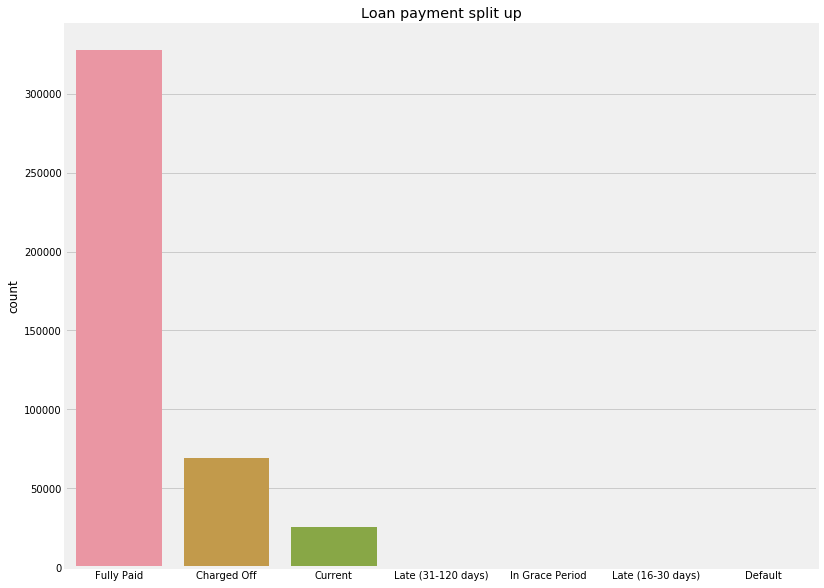

In [6]:
f, ax = plt.subplots(figsize=(12, 10))
x_ticks_labels = ['Fully Paid','Charged Off', 'Current', 'Late (31-120 days)', 
                 'In Grace Period', 'Late (16-30 days)', 'Default']
sns.countplot(df["loan_status"])
ax.set_xticklabels(x_ticks_labels)
ax.set_xlabel('')
ax.set_title('Loan payment split up')

Most of the loans are fully paid, implying a definite bias in favor of fully paid loans, although the skewness is not extreme. 
Only a minuscle number are either late, in grace period or defaulted. We will combine these categories with charged off loans and bucket all of them under 'default', 

It is always a good practice to provide a description of the features, as that helps in understanding the problem domain better.
For a list of feature explanations, please refer to Lending Club's [dictionary](https://help.lendingclub.com/hc/en-us/articles/216127307-Data-Dictionaries)


In [7]:
df.select_dtypes(include=['object']).columns

Index(['grade', 'sub_grade', 'home_ownership', 'verification_status',
       'issue_d', 'loan_status', 'pymnt_plan', 'purpose', 'title', 'zip_code',
       'addr_state', 'revol_util', 'initial_list_status', 'last_pymnt_d',
       'next_pymnt_d', 'last_credit_pull_d', 'application_type',
       'verification_status_joint', 'hardship_flag', 'hardship_type',
       'hardship_reason', 'hardship_status', 'hardship_start_date',
       'hardship_end_date', 'payment_plan_start_date', 'hardship_loan_status',
       'disbursement_method', 'debt_settlement_flag',
       'debt_settlement_flag_date', 'settlement_status', 'settlement_date'],
      dtype='object')

A quick look at the data reveals the following. 

1) Some features are administrative identifiers (e.g. Unnamed: 0). They won't be of any use whatsoever.

2) The features have a wide variety of ranges. Some are numeric, some are boolean while some are categorical. We will need to re-scale them to make them more amenable to some of our classification algorithms. 

3) There are 11 variables of type object, with most of them referring to some date. Those will probably need some attention before they're ready for some of our machine learning models. 

4) Some variables have a lot of null values.

### Data Preprocessing  and Visualization<a id='preprocessing'></a>

Let's begin by pre-preprocessing the data by removing extraneous features and taking care of missing values. 
Any column with more than half of values missing would not be useful. Let's drop those.


In [8]:
half_ct = len(df)/2
df.dropna(axis='columns', thresh=half_ct, inplace=True)

In [9]:
df.info() # This reduces the columns count from 141 to 87

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423844 entries, 0 to 423843
Data columns (total 86 columns):
loan_amnt                     423844 non-null int64
funded_amnt                   423844 non-null int64
funded_amnt_inv               423844 non-null float64
term                          423844 non-null int64
int_rate                      423844 non-null float64
installment                   423844 non-null float64
grade                         423844 non-null object
sub_grade                     423844 non-null object
emp_length                    403937 non-null float64
home_ownership                423844 non-null object
annual_inc                    423844 non-null float64
verification_status           423844 non-null object
issue_d                       423844 non-null object
loan_status                   423844 non-null object
pymnt_plan                    423844 non-null object
purpose                       423844 non-null object
title                         423836 no

##### Features of the type 'Object'
Lets start by considering the features of the type 'object'. 

In [10]:
object_features = df.select_dtypes(include=["object"]).columns.values
object_features
df[object_features].head(10)

,grade,sub_grade,home_ownership,verification_status,issue_d,loan_status,pymnt_plan,purpose,title,zip_code,addr_state,revol_util,initial_list_status,last_pymnt_d,last_credit_pull_d,application_type,hardship_flag,disbursement_method,debt_settlement_flag
0,B,B4,RENT,Verified,Dec-2013,Fully Paid,n,debt_consolidation,debt,322xx,FL,54.2%,f,Jul-2014,Oct-2016,Individual,N,Cash,N
1,A,A3,MORTGAGE,Source Verified,Dec-2013,Fully Paid,n,debt_consolidation,Pay off other Installment loan,945xx,CA,54.6%,w,Aug-2014,Aug-2014,Individual,N,Cash,N
2,E,E4,RENT,Verified,Dec-2013,Fully Paid,n,debt_consolidation,Debt Killer,937xx,CA,70.9%,f,Sep-2017,Dec-2017,Individual,N,Cash,N
3,B,B5,RENT,Source Verified,Dec-2013,Fully Paid,n,debt_consolidation,Debt consolidation,871xx,NM,68.8%,w,Sep-2015,May-2018,Individual,N,Cash,N
4,B,B5,MORTGAGE,Verified,Dec-2013,Fully Paid,n,credit_card,credit card,493xx,MI,76.7%,w,Dec-2015,May-2018,Individual,N,Cash,N
5,A,A5,MORTGAGE,Not Verified,Dec-2013,Fully Paid,n,debt_consolidation,Pay off,334xx,FL,74.2%,w,Jan-2017,Dec-2016,Individual,N,Cash,N
6,B,B4,RENT,Not Verified,Dec-2013,Fully Paid,n,debt_consolidation,Debt consolidation,282xx,NC,81.9%,f,Jan-2017,May-2018,Individual,N,Cash,N
7,A,A2,MORTGAGE,Not Verified,Dec-2013,Fully Paid,n,debt_consolidation,UNIVERSAL CARD,060xx,CT,21.6%,w,Jan-2017,May-2018,Individual,N,Cash,N
8,B,B2,RENT,Not Verified,Dec-2013,Fully Paid,n,debt_consolidation,No Regrets,281xx,NC,24%,f,Apr-2016,May-2018,Individual,N,Cash,N
9,B,B5,RENT,Verified,Dec-2013,Fully Paid,n,debt_consolidation,Reducing Debt to Purchase Home,100xx,NY,54.5%,f,May-2015,May-2018,Individual,N,Cash,N


A few features up here look promising. Lets plot a bar chart for these features.

Text(0.5,1,'Loan split up by home category')

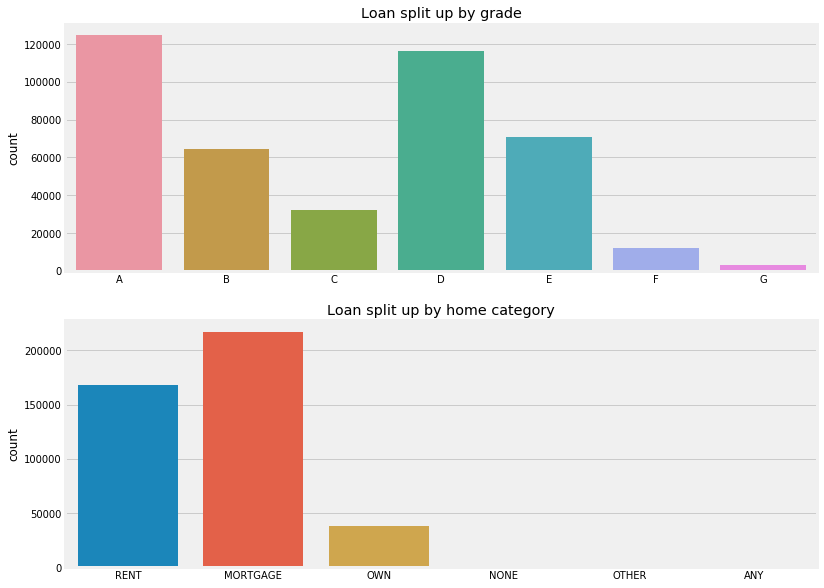

In [11]:
f, (ax1, ax2) = plt.subplots(2, figsize=(12, 10))
x_ticks_labels = ['A','B', 'C', 'D', 
                 'E', 'F', 'G']
sns.countplot(df["grade"], ax=ax1)
ax1.set_xticklabels(x_ticks_labels)
ax1.set_xlabel('')
ax1.set_title('Loan split up by grade')

x_ticks_labels = ['RENT','MORTGAGE', 'OWN', 'NONE', 
                 'OTHER', 'ANY']
sns.countplot(df["home_ownership"], ax=ax2)
ax2.set_xticklabels(x_ticks_labels)
ax2.set_xlabel('')
ax2.set_title('Loan split up by home category')



A couple of things stand out. There are very few loans in the high risk category ('F' and 'G'). The safest loans (grade 'A') have the most number. 

Almost all the borrowers either rent or own a house or are in the process of paying off the mortgages

Text(0.5,1,'Loan purpose split up')

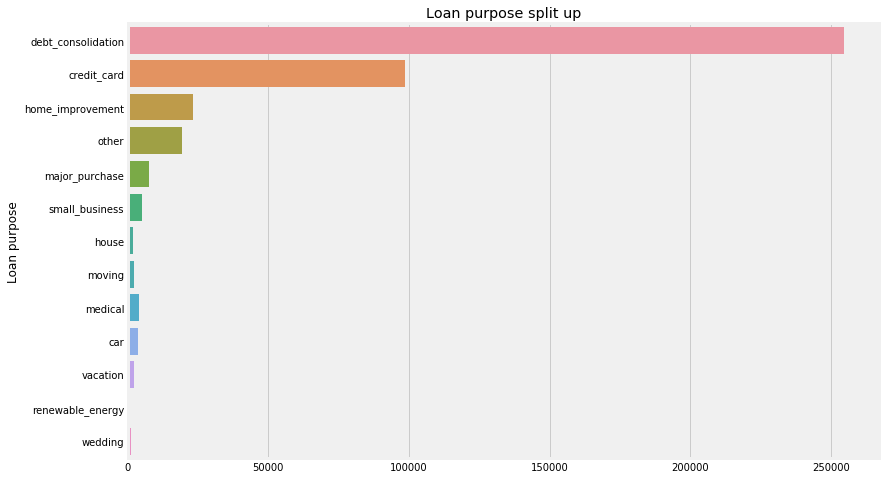

In [12]:
f, ax = plt.subplots(figsize=(12, 8))
sns.countplot(y=df["purpose"])
ax.set_xlabel('')
ax.set_ylabel('Loan purpose')
ax.set_title('Loan purpose split up')

Very interesting. More than 60% of the loans are for debt-consolidation. 

In [13]:
#df.application_type.value_counts()
#df.hardship_flag.value_counts()
#df.disbursement_method.value_counts()
#df.debt_settlement_flag.value_counts()
#df.pymnt_plan.value_counts()

The distribution for the categorical variables `application_type`, `hardship_flag`, `disbursement_method`, 
`debt_settlement_flag` and `pymnt_plan` is heavily skewed, and they mostly take only 1 values. These features will not have any predictive power in machine learning models. Let's drop them, along with `last_pymnt_d`, `last_credit_pull_d` and `issue_d`. Moreover, the zip code feature would be very difficult to use in a machine learning model. Let's drop that too. 

In [14]:
df.drop(['last_pymnt_d', 'last_credit_pull_d', 'application_type', 'hardship_flag', 
         'disbursement_method', 'debt_settlement_flag', 'issue_d', 'pymnt_plan', 'zip_code'], axis=1, inplace=True)

In [15]:
# lets take a quick look at the remaining feature of the type 'Object'
object_features = df.select_dtypes(include=["object"]).columns.values
object_features
df[object_features].head(10)

,grade,sub_grade,home_ownership,verification_status,loan_status,purpose,title,addr_state,revol_util,initial_list_status
0,B,B4,RENT,Verified,Fully Paid,debt_consolidation,debt,FL,54.2%,f
1,A,A3,MORTGAGE,Source Verified,Fully Paid,debt_consolidation,Pay off other Installment loan,CA,54.6%,w
2,E,E4,RENT,Verified,Fully Paid,debt_consolidation,Debt Killer,CA,70.9%,f
3,B,B5,RENT,Source Verified,Fully Paid,debt_consolidation,Debt consolidation,NM,68.8%,w
4,B,B5,MORTGAGE,Verified,Fully Paid,credit_card,credit card,MI,76.7%,w
5,A,A5,MORTGAGE,Not Verified,Fully Paid,debt_consolidation,Pay off,FL,74.2%,w
6,B,B4,RENT,Not Verified,Fully Paid,debt_consolidation,Debt consolidation,NC,81.9%,f
7,A,A2,MORTGAGE,Not Verified,Fully Paid,debt_consolidation,UNIVERSAL CARD,CT,21.6%,w
8,B,B2,RENT,Not Verified,Fully Paid,debt_consolidation,No Regrets,NC,24%,f
9,B,B5,RENT,Verified,Fully Paid,debt_consolidation,Reducing Debt to Purchase Home,NY,54.5%,f


In [16]:
# Let's convert revoling utlties to float and fill in the remaining values
df["revol_util"] = df["revol_util"].str.replace('%','')
df["revol_util"] = df["revol_util"].astype(float)

In [17]:
df["revol_util"].fillna(df["revol_util"].median(), inplace=True)

Lets now look at columns wth lots of null values

In [18]:
df.isnull().sum()

loan_amnt                         0
funded_amnt                       0
funded_amnt_inv                   0
term                              0
int_rate                          0
installment                       0
grade                             0
sub_grade                         0
emp_length                    19907
home_ownership                    0
annual_inc                        0
verification_status               0
loan_status                       0
purpose                           0
title                             8
addr_state                        0
dti                               0
delinq_2yrs                       0
inq_last_6mths                    0
open_acc                          0
pub_rec                           0
revol_bal                         0
revol_util                        0
total_acc                         0
initial_list_status               0
out_prncp                         0
out_prncp_inv                     0
total_pymnt                 

In [19]:
# Replace employment length with median
df["emp_length"].fillna(df["emp_length"].median(), inplace=True)

There may be some columns with more than one unique values but one of the values has insignificant frequency in the dataset. Let's find out and drop such column(s):



In [20]:
for col in df.columns:
    if (len(df[col].unique()) < 4):
        print(df[col].value_counts())
        print()

36    306482
60    117362
Name: term, dtype: int64

Verified           154621
Source Verified    139715
Not Verified       129508
Name: verification_status, dtype: int64

f    260523
w    163321
Name: initial_list_status, dtype: int64

1    423844
Name: policy_code, dtype: int64



Clearly, policy code is not useful. Let's drop it 

In [21]:
df.drop('policy_code', axis=1, inplace=True)

Text(0.5,0,'Loan amount')

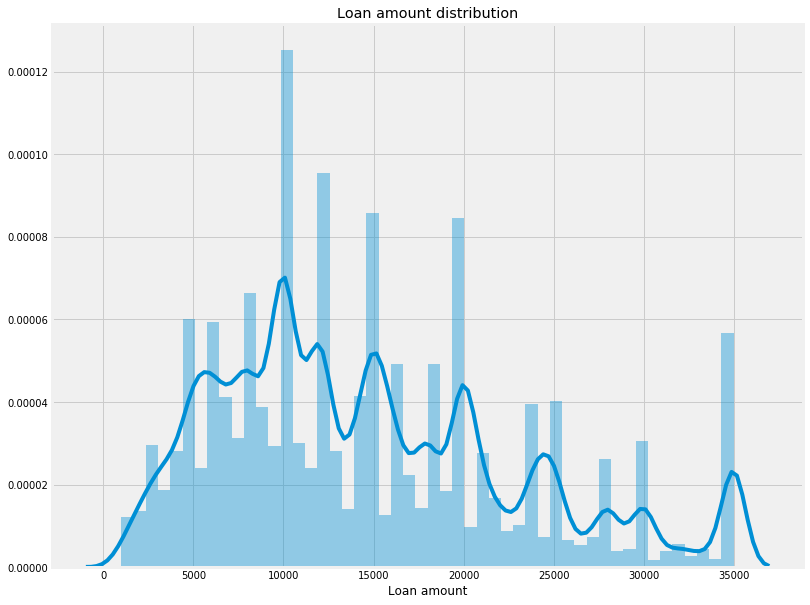

In [23]:
f, ax = plt.subplots(figsize=(12, 10))
sns.distplot(df['loan_amnt'])
ax.set_title('Loan amount distribution')
ax.set_xlabel('Loan amount')

We see a spike in loan amounts in multiples of 1000. This is not too surprising since people tend to take out loans which are rounded off to the nearest thousand. Also note that the highest possible requested loan amount is 35000 USD, which is the upper limit allowed by Lending Club. 

Text(0.5,0,'Credit age')

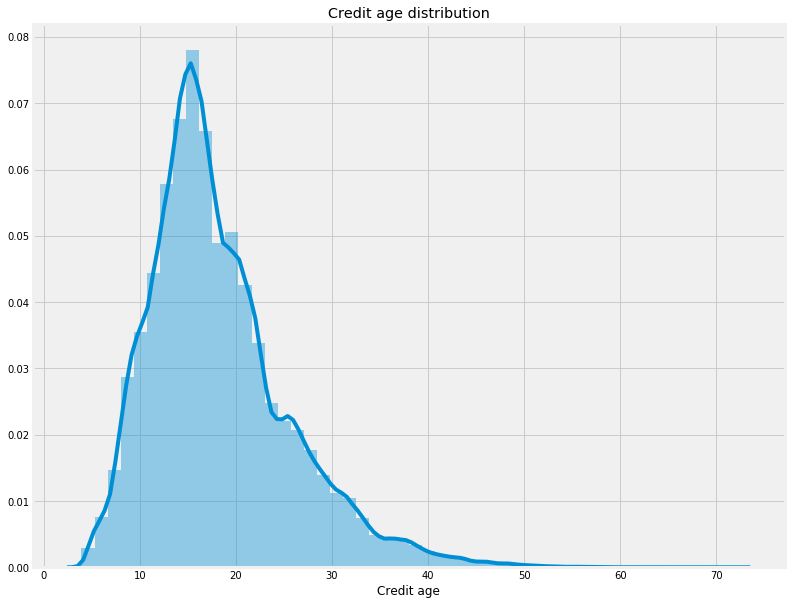

In [24]:
# How about credit age?
f, ax = plt.subplots(figsize=(12, 10))
sns.distplot(df['credit_age'])
ax.set_title('Credit age distribution')
ax.set_xlabel('Credit age')

This is interesting. Most of the borrowers seem to have a less than 15 year credit age, implying that most borrowers on these platforms are perhaps middle aged. 

These columns have lots of null values. The features mostly tie in to the credit history of the borrower. I reason that these features will not have much predictive power in classfication algorithms, since the internal credit rating for Lending club will take all these factors in to account when assigning a loan grade. 


In [25]:
credit_lots_of_null = ['mo_sin_old_il_acct',
'mo_sin_old_rev_tl_op',
'mo_sin_rcnt_rev_tl_op',
'mo_sin_rcnt_tl',
'mort_acc',
'mths_since_recent_bc',
'mths_since_recent_inq',
'num_accts_ever_120_pd',
'num_actv_bc_tl',
'num_actv_rev_tl',
'num_bc_sats',
'num_bc_tl',
'num_il_tl',
'num_op_rev_tl',
'num_rev_accts',
'num_rev_tl_bal_gt_0',
'num_sats',
'num_tl_120dpd_2m',
'num_tl_30dpd',
'num_tl_90g_dpd_24m',
'num_tl_op_past_12m',
'pct_tl_nvr_dlq',
'percent_bc_gt_75',
'tot_coll_amt',
'tot_cur_bal',
'total_rev_hi_lim',
'acc_open_past_24mths',
'avg_cur_bal',
'bc_open_to_buy',
'bc_util', 
'tot_hi_cred_lim',
'total_bal_ex_mort',
'total_bc_limit',
'total_il_high_credit_limit']

In [26]:
df.drop(credit_lots_of_null, axis=1, inplace=True)

In [27]:
df.isnull().sum()

loan_amnt                     0
funded_amnt                   0
funded_amnt_inv               0
term                          0
int_rate                      0
installment                   0
grade                         0
sub_grade                     0
emp_length                    0
home_ownership                0
annual_inc                    0
verification_status           0
loan_status                   0
purpose                       0
title                         8
addr_state                    0
dti                           0
delinq_2yrs                   0
inq_last_6mths                0
open_acc                      0
pub_rec                       0
revol_bal                     0
revol_util                    0
total_acc                     0
initial_list_status           0
out_prncp                     0
out_prncp_inv                 0
total_pymnt                   0
total_pymnt_inv               0
total_rec_prncp               0
total_rec_int                 0
total_re

Lets take a look at some features that could be closely related. All of them involve some sort of 'bad' financial behaviour on part of the borrower. 

In [28]:
bad_credit_cols = ['open_acc', 'pub_rec', 'revol_bal',                     
'recoveries', 'collections_12_mths_ex_med',
'chargeoff_within_12_mths', 'pub_rec_bankruptcies', 'tax_liens']                     

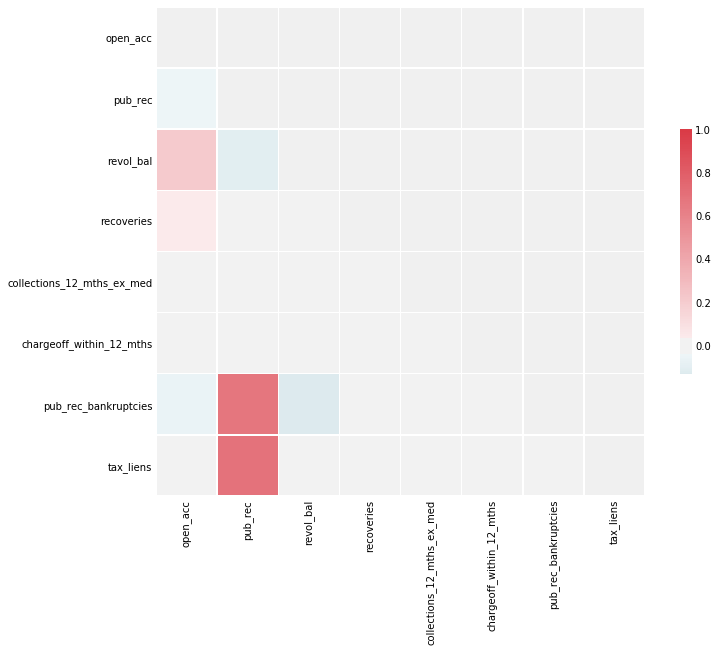

In [29]:
# Compute the correlation matrix
bad_credit_corr = df[bad_credit_cols].corr()

mask = np.zeros_like(bad_credit_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(bad_credit_corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Nothing too surprising here!

### Feature engineering <a id='engineering'></a>

Let's now turn our attention to the loan title. Let's generate new features from the title. 
Before that, let's fill in the remaining nan's in titles.

In [30]:
df['title'] = df['title'].replace(np.nan, '')

Let's create a dataframe of title polarity and sentiment 

In [31]:
df_polsub = df['title'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment)) # Sentiment returns a dataframe of the form 
                                                                                # (polarity, subjectivity).

Text(0,0.5,'Percentage of values')

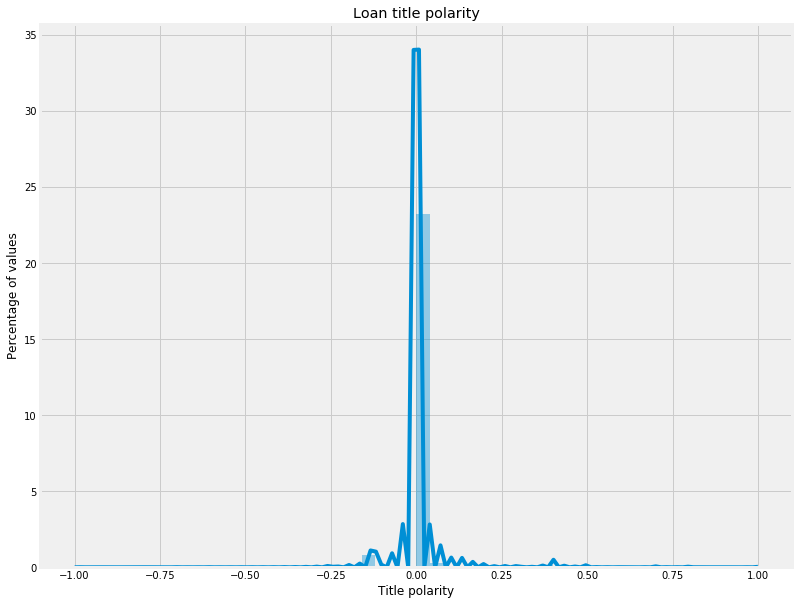

In [32]:
f, ax = plt.subplots(figsize=(12, 10))
sns.distplot(df_polsub[0])
ax.set_title('Loan title polarity')
ax.set_xlabel('Title polarity')
ax.set_ylabel('Percentage of values')

Text(0,0.5,'Percentage of values')

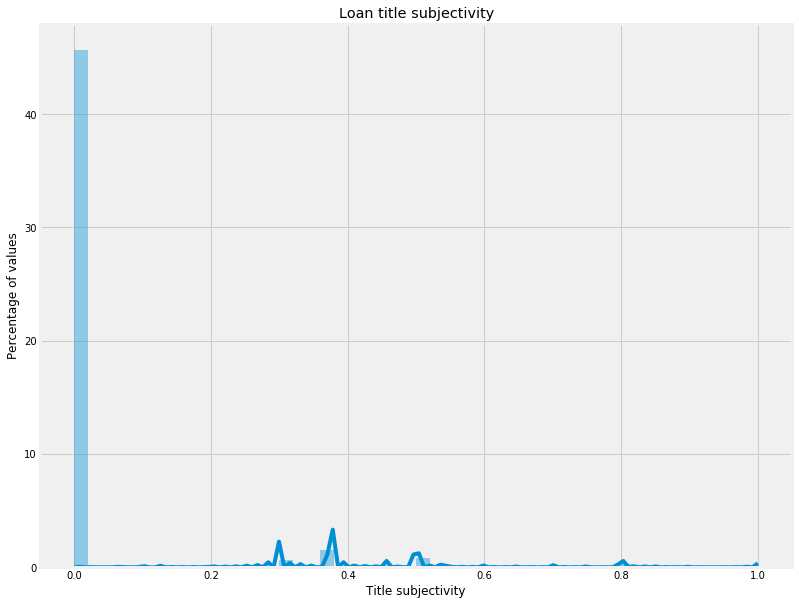

In [33]:
f, ax = plt.subplots(figsize=(12, 10))
sns.distplot(df_polsub[1])
ax.set_title('Loan title subjectivity')
ax.set_xlabel('Title subjectivity')
ax.set_ylabel('Percentage of values')

Not surprisingly, most of the titles have no polarity or subjectivity.

In [34]:
def count_words(text):
    return len(text.split())

In [35]:
df['title_word_count'] = df['title'].apply(count_words)

In [36]:
df['title_polarity'] = df_polsub[0]

In [37]:
df['title_subjectivity'] = df_polsub[1]

In [38]:
df['title_length'] = df['title'].apply(len)

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423844 entries, 0 to 423843
Data columns (total 46 columns):
loan_amnt                     423844 non-null int64
funded_amnt                   423844 non-null int64
funded_amnt_inv               423844 non-null float64
term                          423844 non-null int64
int_rate                      423844 non-null float64
installment                   423844 non-null float64
grade                         423844 non-null object
sub_grade                     423844 non-null object
emp_length                    423844 non-null float64
home_ownership                423844 non-null object
annual_inc                    423844 non-null float64
verification_status           423844 non-null object
loan_status                   423844 non-null object
purpose                       423844 non-null object
title                         423844 non-null object
addr_state                    423844 non-null object
dti                           423844 no

Let's engineer a new feature `loan-to-income ratio`. Intuitively, it makes sense that a higher loan-to-income ratio indicates 
a lack of future credit worthiness of the borrower. 

In [40]:
df['lti'] = df.loan_amnt/ df.annual_inc

This finishes the intial exploratory analysis and cleaning for purposes of classfication. Let's save the dataframe which will later be used for classification.

In [42]:
df.to_pickle('agg_data/classfication_df.pkl')